# Estudo sobre o artigo "Pruning Feedforward Polynomial Neural with Smoothing Elastic Net Regularization"

**Aluno**: Vítor Gabriel Reis Caitité

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve
import seaborn as sns


## Aproximação suave da função valor absoluto

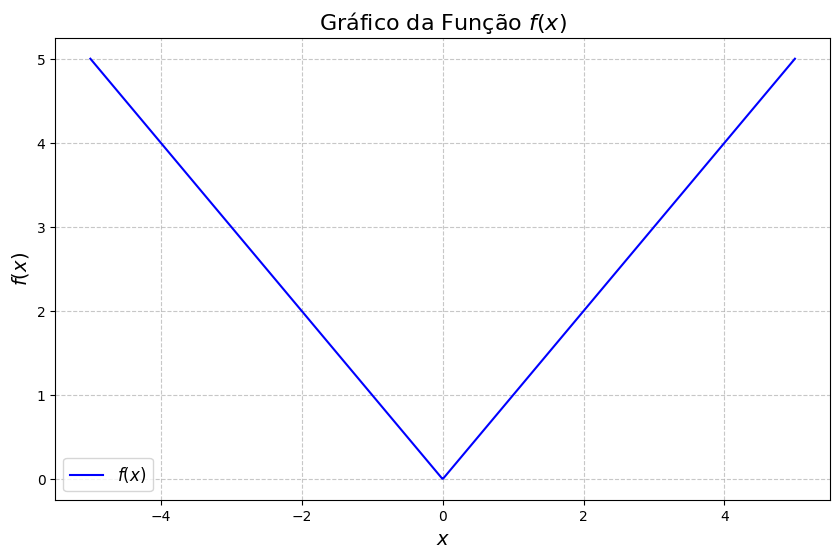

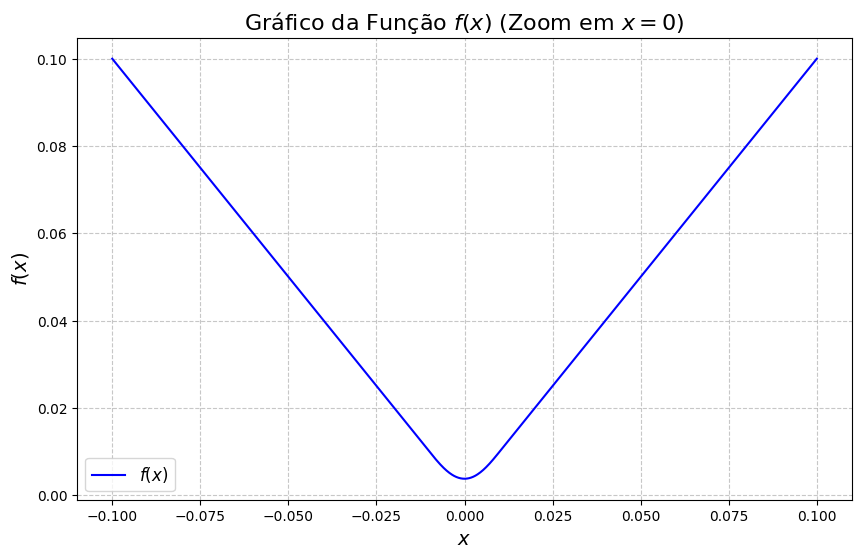

In [16]:
# Definindo a função
def f_function(x):
    gamma = 0.01
    if abs(x) > gamma:
        return abs(x)
    else:
        return -(x**4)/(8*gamma**3) + (3*x**2)/(4*gamma) + (3*gamma)/8

# Criando um array de valores de x no intervalo [-5, 5]
x_values = np.linspace(-5, 5, 1000)

# Calculando os valores de y para cada x
y_values = np.array([f_function(x) for x in x_values])

# Plotando a função
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label=r'$f(x)$', color='blue')
plt.title('Gráfico da Função $f(x)$', fontsize=16)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()


x_values = np.linspace(-0.1, 0.1, 1000)
y_values = np.array([f_function(x) for x in x_values])

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label=r'$f(x)$', color='blue')
plt.title('Gráfico da Função $f(x)$ (Zoom em $x=0$)', fontsize=16)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()


## Implementation of Pi Sigma Neural Network 

In [2]:
class PiSigmaNN:

    def __init__(self, input_size, hidden_size, learning_rate=0.1, tol=1e-5, patience=200):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.W1 = np.random.randn(hidden_size, input_size) * 0.1  # Hidden layer weights
        self.b1 = np.random.randn(hidden_size) * 0.1              # Hidden layer biases
        self.tol = tol
        self.patience = patience

    
    # Function to apply the forward step of NN
    def forward(self, X):
        # Sigma Units:
        self.sigma = np.dot(X, self.W1.T) + self.b1  # Linear combination of each input feature multiplied by its corresponding weight. 
        # Pi Unit:
        self.output = np.prod(self.sigma, axis=1, keepdims=True)            # The output is directly the product of the sigma units. 
        return self.output
    
    # Backpropagation step:
    def backward(self, X, y):
        batch_size = X.shape[0]

        # Error at output layer:
        output_error = self.output - y 
        
        # Gradient of the sigma units:
        grad_sigma = output_error * (self.output / self.sigma)
        
        # Gradient of the weights (dW) and biases (db)
        dW = np.dot(grad_sigma.T, X) / batch_size  # (hidden_units, input_dim)
        db = np.mean(grad_sigma, axis=0)  # (hidden_units,)
              
        # Update weights and biases
        self.W1 -= self.learning_rate * dW
        self.b1 -= self.learning_rate * db

    
    # Function to train NN:
    def fit(self, X, y, epochs=10000):
        losses = []
        best_loss = np.inf
        wait = 0
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y)
            # Compute and store the loss
            loss = np.mean((self.output - y) ** 2)
            losses.append(loss)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
            # Early stopping (Stop training if loss hasn't improved for 'patience' epochs):
            if loss < best_loss - self.tol:
                best_loss = loss
                wait = 0  
            else:
                wait += 1 
            if wait >= self.patience:
                print(f"Early stopping at epoch {epoch} with loss {loss:.4f}")
                break

        return losses, epoch
    
    # Function to apply the NN and return the predicted result
    def predict(self, X):
        output = self.forward(X)
        return output

Epoch 0, Loss: 0.5156
Epoch 100, Loss: 0.5155
Epoch 200, Loss: 0.5155
Epoch 300, Loss: 0.5155
Epoch 400, Loss: 0.5155
Epoch 500, Loss: 0.5154
Epoch 600, Loss: 0.5154
Epoch 700, Loss: 0.5154
Epoch 800, Loss: 0.5154
Epoch 900, Loss: 0.5154
Epoch 1000, Loss: 0.5154
Epoch 1100, Loss: 0.5154
Epoch 1200, Loss: 0.5153
Epoch 1300, Loss: 0.5153
Epoch 1400, Loss: 0.5152
Epoch 1500, Loss: 0.5150
Epoch 1600, Loss: 0.5141
Epoch 1700, Loss: 0.5060
Epoch 1800, Loss: 0.4802
Epoch 1900, Loss: 0.4471
Epoch 2000, Loss: 0.3858
Epoch 2100, Loss: 0.0791
Epoch 2200, Loss: 0.0073
Epoch 2300, Loss: 0.0027
Epoch 2400, Loss: 0.0011
Epoch 2500, Loss: 0.0010
Epoch 2600, Loss: 0.0009
Epoch 2700, Loss: 0.0009
Early stopping at epoch 2774 with loss 0.0009


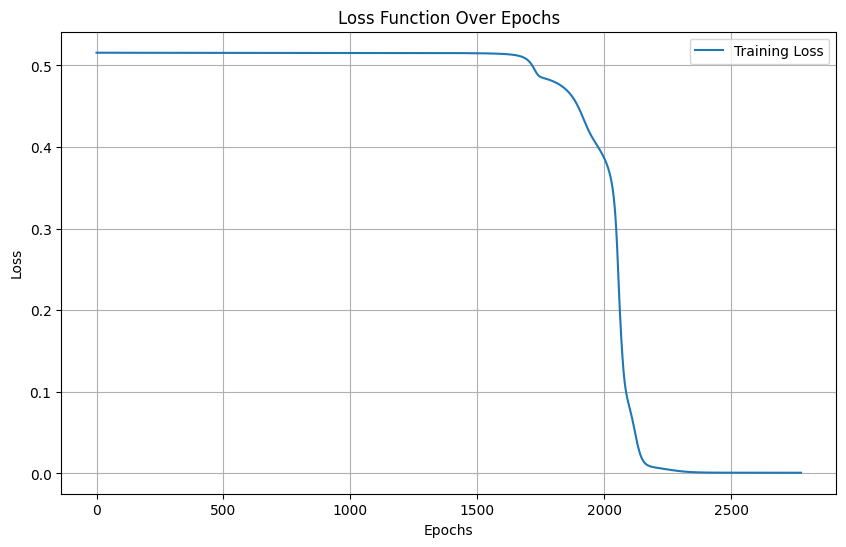

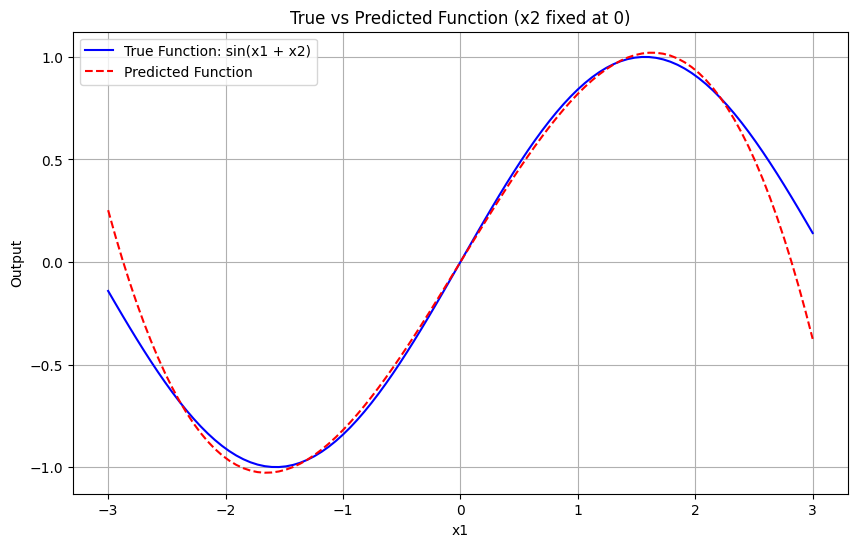

In [3]:
# Generate synthetic data
np.random.seed(42)
X = np.random.randn(100, 2)  # 100 samples, 2 features
y = np.sin(X[:, 0] + X[:, 1]).reshape(-1, 1)  # Target function: sin(x1 + x2)

# Initialize the Pi-Sigma Network
input_dim = 2
hidden_units = 5  # Increased hidden units for better approximation
psnn = PiSigmaNN(input_dim, hidden_units)

# Train the network
losses, epochs = psnn.fit(X, y)

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs+1), losses, label="Training Loss")  # Pass range(epochs) as x-axis
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Fix x2 and vary x1 to visualize the learned function
x2_fixed = 0.0  # Fix x2 to a constant value
x1_values = np.linspace(-3, 3, 100)  # Vary x1 from -3 to 3
X_test = np.column_stack((x1_values, np.full_like(x1_values, x2_fixed)))  # Create test data
y_pred = psnn.forward(X_test)  # Predict using the trained network

# Compute the true values for the test data
y_true = np.sin(X_test[:, 0] + X_test[:, 1])

# Plot the original curve and the predicted curve
plt.figure(figsize=(10, 6))
plt.plot(x1_values, y_true, label="True Function: sin(x1 + x2)", color="blue")
plt.plot(x1_values, y_pred, label="Predicted Function", color="red", linestyle="--")
plt.xlabel("x1")
plt.ylabel("Output")
plt.title("True vs Predicted Function (x2 fixed at 0)")
plt.legend()
plt.grid()
plt.show()

## Criação dos Dados Sintéticos

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Gerar dados sintéticos
np.random.seed(42)
n_samples = 1000
n_features = 20

# Gerar features aleatórias
X = np.random.randn(n_samples, n_features)

# Gerar pesos verdadeiros (apenas 5 features são relevantes)
true_weights = np.zeros(n_features)
true_weights[:5] = [1.5, -2.0, 3.0, -1.0, 2.5]

# Gerar target (com ruído)
y = X.dot(true_weights) + np.random.randn(n_samples) * 0.5

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Construção das Redes Neurais

Vamos criar três modelos:

1. Elastic Net Regularization (combinação de L1 e L2).

2. L1 Regularization (Lasso).

3. L2 Regularization (Ridge).

In [5]:
from keras import models, layers, regularizers

# Parâmetros de regularização
lambda_l1 = 0.1
lambda_l2 = 0.1

# Função para criar modelos
def create_model(regularizer):
    model = models.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
        layers.Dense(1, activation='linear')  # Saída para regressão
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Modelo com Elastic Net
elastic_net_reg = regularizers.L1L2(l1=lambda_l1, l2=lambda_l2)
model_elastic_net = create_model(elastic_net_reg)

# Modelo com L1 Regularization
l1_reg = regularizers.L1(l1=lambda_l1)
model_l1 = create_model(l1_reg)

# Modelo com L2 Regularization
l2_reg = regularizers.L2(l2=lambda_l2)
model_l2 = create_model(l2_reg)

# Modelo sem regularização
model_no_reg = create_model(None)

2025-02-04 17:41:12.025688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 17:41:14.023267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 17:41:15.180845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738701676.173674    3838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738701676.455320    3838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 17:41:18.453908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [6]:
# Treinar os modelos
history_elastic_net = model_elastic_net.fit(X_train, y_train, epochs=1000, batch_size=32, 
                                            validation_split=0.2, verbose=0)
history_l1 = model_l1.fit(X_train, y_train, epochs=1000, batch_size=32, 
                          validation_split=0.2, verbose=0)
history_l2 = model_l2.fit(X_train, y_train, epochs=1000, batch_size=32, 
                          validation_split=0.2, verbose=0)
history_no_reg = model_no_reg.fit(X_train, y_train, epochs=1000, batch_size=32, 
                                  validation_split=0.2, verbose=0)

Loss Sem Regularização: 0.5633
Loss Elastic Net: 0.6026
Loss L1: 0.5547
Loss L2: 0.4675


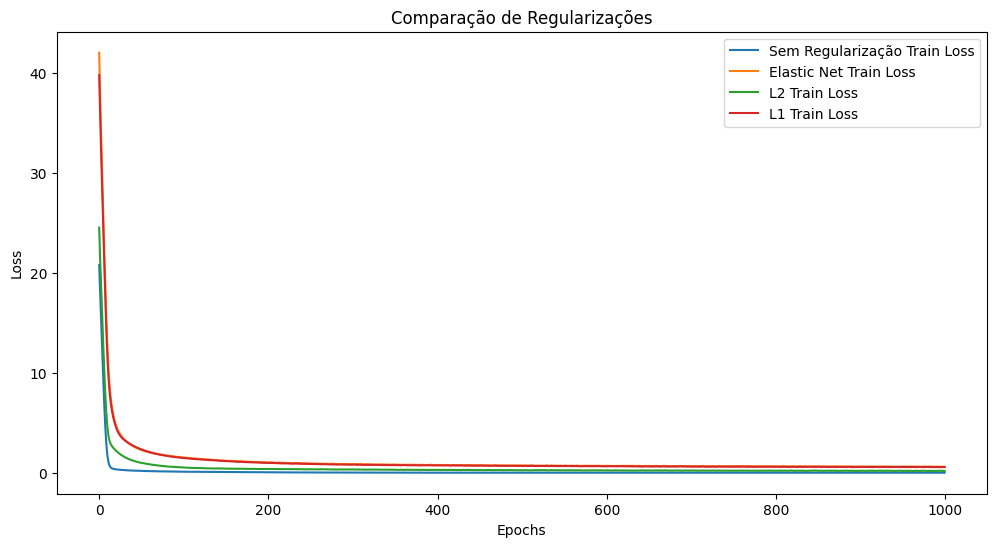

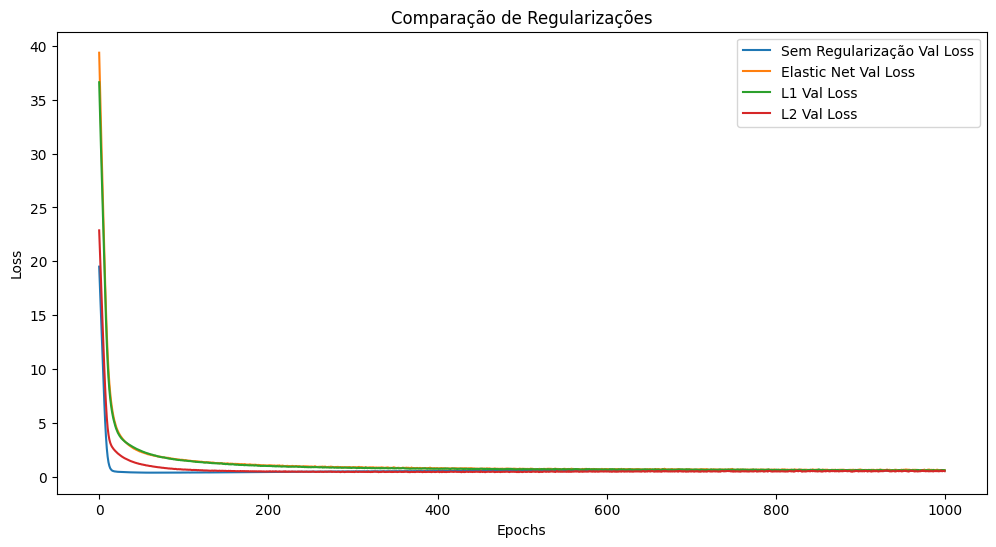

In [7]:
# Avaliar no conjunto de teste
loss_elastic_net = model_elastic_net.evaluate(X_test, y_test, verbose=0)
loss_l1 = model_l1.evaluate(X_test, y_test, verbose=0)
loss_l2 = model_l2.evaluate(X_test, y_test, verbose=0)
loss_no_reg = model_no_reg.evaluate(X_test, y_test, verbose=0)

print(f"Loss Sem Regularização: {loss_no_reg:.4f}")
print(f"Loss Elastic Net: {loss_elastic_net:.4f}")
print(f"Loss L1: {loss_l1:.4f}")
print(f"Loss L2: {loss_l2:.4f}")

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.plot(history_no_reg.history['loss'], label='Sem Regularização Train Loss')
plt.plot(history_elastic_net.history['loss'], label='Elastic Net Train Loss')
plt.plot(history_l2.history['loss'], label='L2 Train Loss')
plt.plot(history_l1.history['loss'], label='L1 Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparação de Regularizações')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(history_no_reg.history['val_loss'], label='Sem Regularização Val Loss')
plt.plot(history_elastic_net.history['val_loss'], label='Elastic Net Val Loss')
plt.plot(history_l1.history['val_loss'], label='L1 Val Loss')
plt.plot(history_l2.history['val_loss'], label='L2 Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparação de Regularizações')
plt.legend()
plt.show()

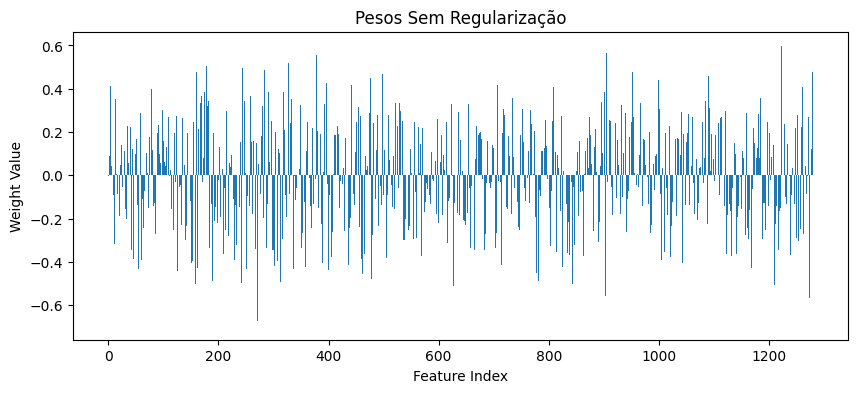

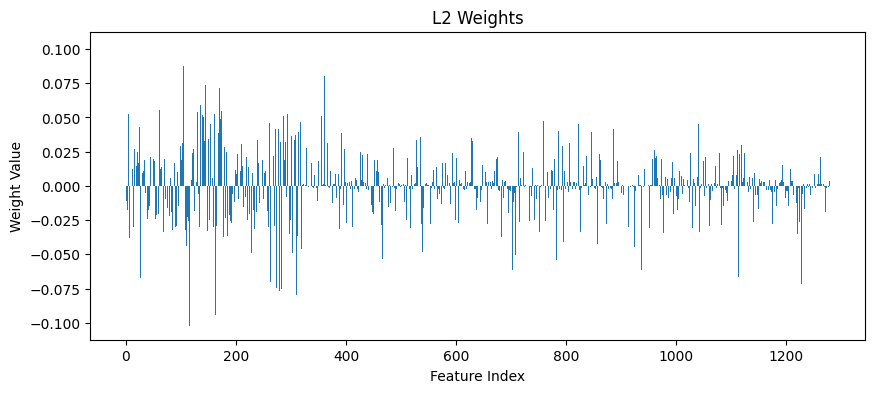

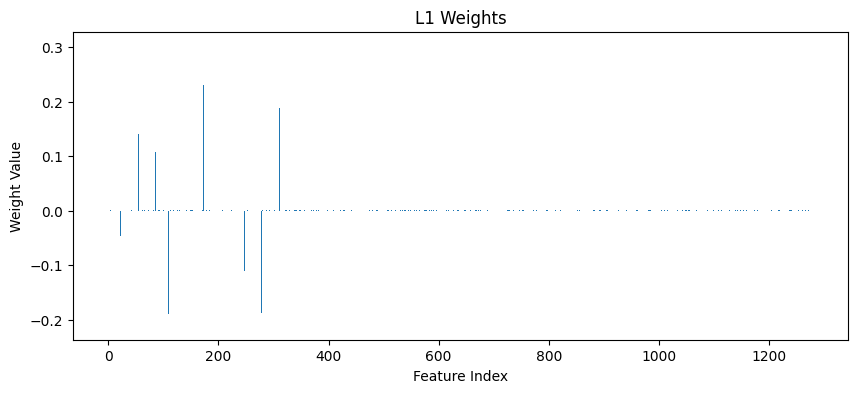

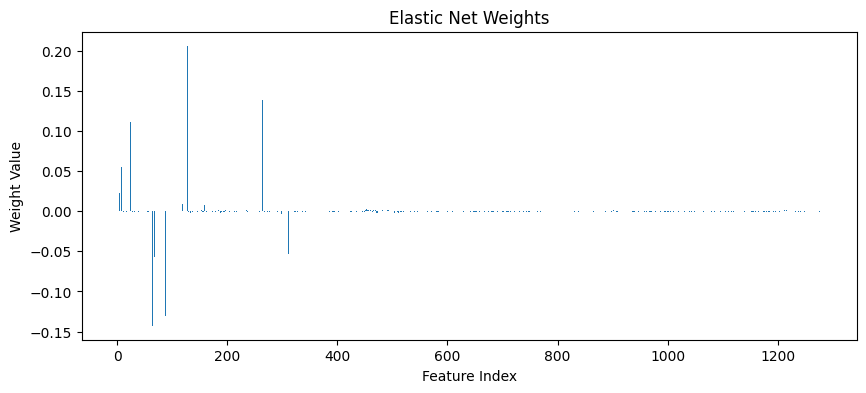

In [8]:
# Função para plotar pesos
def plot_weights(model, title):
    weights = model.layers[0].get_weights()[0].flatten()
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(weights)), weights)
    plt.title(title)
    plt.xlabel('Feature Index')
    plt.ylabel('Weight Value')
    plt.show()

# Plotar pesos
plot_weights(model_no_reg, 'Pesos Sem Regularização')
plot_weights(model_l2, 'L2 Weights')
plot_weights(model_l1, 'L1 Weights')
plot_weights(model_elastic_net, 'Elastic Net Weights')